In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import random
import time

from sklearn.model_selection import cross_validate, train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn import preprocessing, datasets
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

import mlrose_hiive


In [2]:
SEED = 2023
random.seed(SEED)

In [9]:
def queens_max(state):
    fitness_cnt = 0
    for i in range(len(state) - 1):
        for j in range(i + 1, len(state)):

            if (state[j] != state[i]) \
            and (state[j] != state[i] + (j - i)) \
            and (state[j] != state[i] - (j - i)):
                fitness_cnt += 1

    return fitness_cnt

fitness = mlrose_hiive.CustomFitness(queens_max)
problem = mlrose_hiive.DiscreteOpt(length = 32, fitness_fn = fitness, maximize=True, max_val=8)

## Random Hill Climb

In [10]:
%%time

model_rhc = mlrose_hiive.RHCRunner(problem, experiment_name="RHC", 
                                       iteration_list=[10000],
                                       seed=SEED, max_attempts=20, 
                                       restart_list=[20])
rhc_stats, rhc_curves = model_rhc.run()

CPU times: user 1.37 s, sys: 13.8 ms, total: 1.39 s
Wall time: 1.38 s


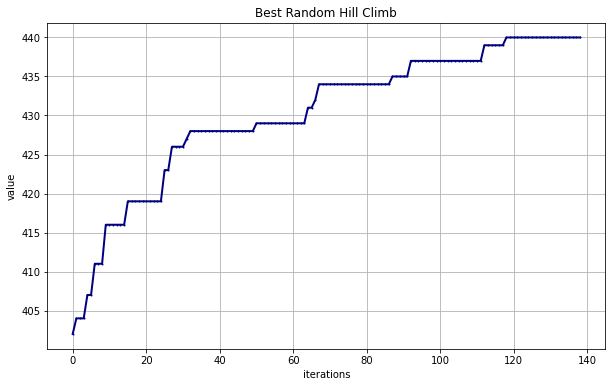

In [11]:
best_idx = rhc_curves.Fitness.idxmax()
best_decay = rhc_curves.iloc[best_idx].current_restart
best_curve = rhc_curves.loc[rhc_curves.current_restart == best_decay, :]
best_curve.reset_index(inplace=True)
best_decay

ax = best_curve.Fitness.plot(lw=2, colormap='jet', marker='.', markersize=2, 
                             figsize=(10,6), grid=1,
                             title='Best Random Hill Climb')
ax.set_xlabel("iterations")
ax.set_ylabel("value")
plt.show()

In [12]:
last_iters = rhc_curves[rhc_curves.Iteration != 0].reset_index()
pd.DataFrame({'Fitness': {'max': last_iters.Fitness.max(), 'mean': last_iters.Fitness.mean()},
             'Time': {'max': last_iters.Time.max(), 'mean': last_iters.Time.mean()}})



,Fitness,Time
max,440.00000,0.096081
mean,425.91558,0.030861


## Simulated Annealing

In [13]:
%%time
model_sa = mlrose_hiive.SARunner(problem, experiment_name="SA", 
                           iteration_list=[10000],
                           temperature_list=[1, 10, 50, 100, 250],
                           decay_list=[mlrose_hiive.ExpDecay,
                                       mlrose_hiive.GeomDecay],
                           seed=SEED, max_attempts=10)

sa_stats, sa_curves = model_sa.run()   

CPU times: user 5.24 s, sys: 54.8 ms, total: 5.3 s
Wall time: 5.29 s


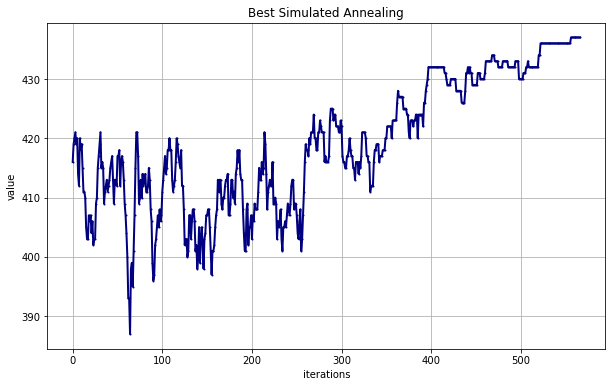

In [14]:
best_idx = sa_curves.Fitness.idxmax()
best_decay = sa_curves.iloc[best_idx].Temperature
best_curve = sa_curves.loc[sa_curves.Temperature == best_decay, :]
best_curve.reset_index(inplace=True)
best_decay

ax = best_curve.Fitness.plot(lw=2, colormap='jet', marker='.', markersize=2, 
                             figsize=(10,6), grid=1,
                             title='Best Simulated Annealing')
ax.set_xlabel("iterations")
ax.set_ylabel("value")
plt.show()

In [15]:
last_iters = sa_stats[sa_stats.Iteration != 0].reset_index()
pd.DataFrame({'Fitness': {'max': last_iters.Fitness.max(), 'mean': last_iters.Fitness.mean()},
             'Time': {'max': last_iters.Time.max(), 'mean': last_iters.Time.mean()}})


,Fitness,Time
max,437.0,1.345688
mean,431.8,0.521760


## Genetic Algo

In [16]:
%%time
model_ga = mlrose_hiive.GARunner(problem=problem,
                          experiment_name="GA",
                          seed=SEED,
                          iteration_list=[10000],
                          max_attempts=100,
                          population_sizes=[20,50,100],
                          mutation_rates=[0.1, 0.25, 0.5])
ga_stats, ga_curves = model_ga.run()   

CPU times: user 52.4 s, sys: 191 ms, total: 52.6 s
Wall time: 52.9 s


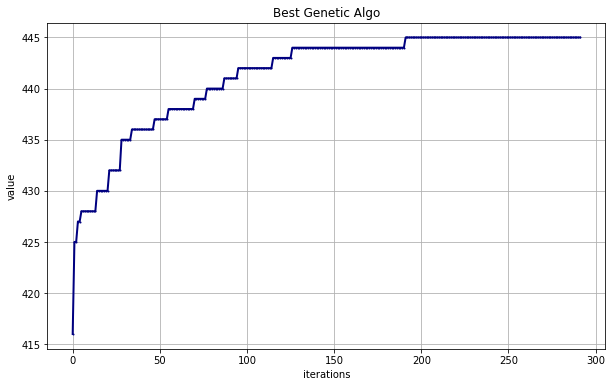

In [17]:
best_idx = ga_curves.Fitness.idxmax()
best_pop_size = ga_curves.iloc[best_idx]['Population Size']
best_mut_rate = ga_curves.iloc[best_idx]['Mutation Rate']
best_curve = ga_curves.loc[(ga_curves['Population Size'] == best_pop_size)&
                           (ga_curves['Mutation Rate'] == best_mut_rate), :]
best_curve.reset_index(inplace=True)

ax = best_curve.Fitness.iloc[:].plot(lw=2, colormap='jet', marker='.', markersize=2, 
                             figsize=(10,6), grid=1,
                             title='Best Genetic Algo')
ax.set_xlabel("iterations")
ax.set_ylabel("value")
plt.show()

In [18]:
last_iters = ga_stats[ga_stats.Iteration != 0].reset_index()
print('max:', last_iters.Fitness.max(), '\n', 
      'mean:', last_iters.Fitness.mean(), last_iters.Time.mean())
df1 = pd.DataFrame({"Mutation Rate": last_iters.groupby("Mutation Rate").Fitness.mean().to_dict()})
df1=df1.reset_index()
df1.columns=['Mutation Rate', 'Fitness']
df2 = pd.DataFrame({"Population Size": last_iters.groupby("Population Size").Fitness.mean().to_dict()})
df2=df2.reset_index()
df2.columns=['Population Size', 'Fitness']
pd.concat([df1,df2],axis=1)

max: 445.0 
 mean: 441.8888888888889 5.871854590222224


,Mutation Rate,Fitness,Population Size,Fitness
0,0.10,440.333333,20,440.000000
1,0.25,442.666667,50,443.000000
2,0.50,442.666667,100,442.666667


##  MIMIC

In [19]:
%%time
model_mmc = mlrose_hiive.MIMICRunner(problem=problem,
                          experiment_name="MMC",
                          seed=SEED,
                          iteration_list=[100],
                          max_attempts=20,
                          population_sizes=[20,50,100],
                          keep_percent_list=[0.25, 0.5, 0.75],
                          use_fast_mimic=True)

mmc_stats, mmc_curves = model_mmc.run()

CPU times: user 14.1 s, sys: 175 ms, total: 14.3 s
Wall time: 14.4 s


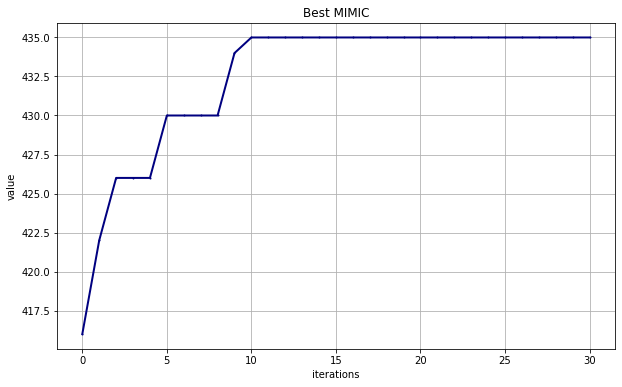

In [20]:
best_idx = mmc_curves.Fitness.idxmax()
best_pop_size = mmc_curves.iloc[best_idx]['Population Size']
best_keep_pct = mmc_curves.iloc[best_idx]['Keep Percent']
best_curve = mmc_curves.loc[(mmc_curves['Population Size'] == best_pop_size)&
                           (mmc_curves['Keep Percent'] == best_keep_pct), :]
best_curve.reset_index(inplace=True)

ax = best_curve.Fitness.plot(lw=2, colormap='jet', marker='.', markersize=2, 
                             figsize=(10,6), grid=1,
                             title='Best MIMIC')
ax.set_xlabel("iterations")
ax.set_ylabel("value")
plt.show()

In [21]:
last_iters = mmc_stats[mmc_stats.Iteration != 0].reset_index()
print('max:', last_iters.Fitness.max(), '\n', 
      'mean:', last_iters.Fitness.mean(), last_iters.Time.mean())
df1 = pd.DataFrame({"Keep Percent": last_iters.groupby("Keep Percent").Fitness.mean().to_dict()})
df1=df1.reset_index()
df1.columns=['Keep Percent', 'Fitness']
df2 = pd.DataFrame({"Population Size": last_iters.groupby("Population Size").Fitness.mean().to_dict()})
df2=df2.reset_index()
df2.columns=['Population Size', 'Fitness']
pd.concat([df1,df2],axis=1)

max: 435.0 
 mean: 429.77777777777777 1.598801818777771


,Keep Percent,Fitness,Population Size,Fitness
0,0.25,428.333333,20,425.333333
1,0.50,430.000000,50,430.000000
2,0.75,431.000000,100,434.000000
